# Libraries Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

from skimage import io, color #Scikit-Image
from PIL import Image # Pillow
import cv2

import os
import random

import torch # Will work on using PyTorch here later
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from google.colab import drive

print(torch.__version__)

1.13.0+cu117


In [ ]:
drive.mount('/content/gdrive')

# Load Datasets

In [ ]:
parent_folder = '/content/gdrive/MyDrive/HC18'
data_folder = '/content/gdrive/MyDrive/HC18/data'

In [ ]:
class HC18(Dataset):
    def __init__(self, train = True, transformX = None, transformY = None):
        self.pixel_file = pd.read_csv(os.path.join(data_folder, 'training_set_pixel_size_and_HC.csv'))
        self.transformX = transformX
        self.transformY = transformY
        self.train = train
        self.train_data, self.validation_data = train_test_split(self.pixel_file, test_size = validation_set_size, random_state = 5)

    def __len__(self):
        if self.train:
            return len(self.train_data)
        return len(self.validation_data)
    
    def __getitem__(self, index):
        if self.train:
            imx_name = os.path.join(data_folder, 'training_set', self.train_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set', self.train_data.iloc[index, 0].replace('.png','_Annotation.png'))
        else:
            imx_name = os.path.join(data_folder, 'training_set', self.validation_data.iloc[index, 0])
            imy_name = os.path.join(data_folder, 'training_set', self.validation_data.iloc[index, 0].replace('.png','_Annotation.png'))
        imx = Image.open(imx_name)
        imy = Image.open(imy_name).convert('L')
        
        ## tried some data augmentation techniques
        if self.train:
          # Random horizontal flipping
          if random.random() > 0.5:
              imx = TF.hflip(imx)
              imy = TF.hflip(imy)

          # Random vertical flipping
          if random.random() > 0.5:
              imx = TF.vflip(imx)
              imy = TF.vflip(imy)

          # Random rotation
          if random.random() > 0.8:
            angle = random.choice([-30, -90, -60, -45 -15, 0, 15, 30, 45, 60, 90])
            imx = TF.rotate(imx, angle)
            imy = TF.rotate(imy, angle)
        
        # We will use resize, tensorlize, and normalize in the following cell
        if self.transformX :
            imx = self.transformX(imx)
            imy = self.transformY(imy)
        
        sample = {'image': imx, 'annotation': imy}
        return sample

In [ ]:
with open(os.path.join(parent_folder, 'train_data.pickle'), 'rb') as f:
    train_data = pickle.load(f)
with open(os.path.join(parent_folder, 'validation_data.pickle'), 'rb') as f:
    validation_data = pickle.load(f)

# Dataloaders
train_loader = DataLoader(dataset = train_data, batch_size = 2)
validation_loader = DataLoader(dataset = validation_data, batch_size = 2)

# Build the Model

# Unet++

In [ ]:
from torch.nn import init

def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [ ]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x

class unetUp(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp, self).__init__()
        # self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
        self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        # print(self.n_concat)
        # print(input)
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)
    
class unetUp_origin(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp_origin, self).__init__()
        # self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        else:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        x1 = self.up(inputs0)
        # input is CHW
        for i in range(len(input)):
            try:
                x1 = torch.cat((x1,input[i]),1)
            except:
                x1 = torch.cat((F.pad(x1,(1,0,1,0)),input[i]),1)
        return self.conv(x1)

In [ ]:
class UNet_2Plus(nn.Module):
    def __init__(self, in_channels=1, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True, is_ds=True):
        super(UNet_2Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.is_ds = is_ds
        self.feature_scale = feature_scale

        filters = [64, 128, 256, 512, 1024]

        # downsampling
        self.conv00 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool0 = nn.MaxPool2d(kernel_size=2)
        self.conv10 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv20 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv30 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv40 = unetConv2(filters[3], filters[4], self.is_batchnorm)


        # upsampling
        self.up_concat01 = unetUp_origin(filters[1], filters[0], self.is_deconv)
        self.up_concat11 = unetUp_origin(filters[2], filters[1], self.is_deconv)
        self.up_concat21 = unetUp_origin(filters[3], filters[2], self.is_deconv)
        self.up_concat31 = unetUp_origin(filters[4], filters[3], self.is_deconv)

        self.up_concat02 = unetUp_origin(filters[1], filters[0], self.is_deconv, 3)
        self.up_concat12 = unetUp_origin(filters[2], filters[1], self.is_deconv, 3)
        self.up_concat22 = unetUp_origin(filters[3], filters[2], self.is_deconv, 3)

        self.up_concat03 = unetUp_origin(filters[1], filters[0], self.is_deconv, 4)
        self.up_concat13 = unetUp_origin(filters[2], filters[1], self.is_deconv, 4)

        self.up_concat04 = unetUp_origin(filters[1], filters[0], self.is_deconv, 5)

        # final conv (without any concat)
        self.final_1 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_2 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_3 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_4 = nn.Conv2d(filters[0], n_classes, 1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        # column : 0
        X_00 = self.conv00(inputs)
        maxpool0 = self.maxpool0(X_00)
        X_10 = self.conv10(maxpool0)
        maxpool1 = self.maxpool1(X_10)
        X_20 = self.conv20(maxpool1)
        maxpool2 = self.maxpool2(X_20)
        X_30 = self.conv30(maxpool2)
        maxpool3 = self.maxpool3(X_30)
        X_40 = self.conv40(maxpool3)

        # column : 1
        X_01 = self.up_concat01(X_10, X_00)
        X_11 = self.up_concat11(X_20, X_10)
        X_21 = self.up_concat21(X_30, X_20)
        X_31 = self.up_concat31(X_40, X_30)
        # column : 2
        X_02 = self.up_concat02(X_11, X_00, X_01)
        X_12 = self.up_concat12(X_21, X_10, X_11)
        X_22 = self.up_concat22(X_31, X_20, X_21)
        # column : 3
        X_03 = self.up_concat03(X_12, X_00, X_01, X_02)
        X_13 = self.up_concat13(X_22, X_10, X_11, X_12)
        # column : 4
        X_04 = self.up_concat04(X_13, X_00, X_01, X_02, X_03)

        # final layer
        final_1 = self.final_1(X_01)
        final_2 = self.final_2(X_02)
        final_3 = self.final_3(X_03)
        final_4 = self.final_4(X_04)

        final = (final_1 + final_2 + final_3 + final_4) / 4

        if self.is_ds:
            return F.sigmoid(final)
        else:
            return F.sigmoid(final_4)

In [ ]:
model = UNet_2Plus()
model.to('cuda')
print("Model Loaded to GPU")

Model Loaded to GPU


In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
# calculates similarity index between predicted and actual segmentation
def dice_index(y_pred, y_actual):
    smooth = 0.000001
    size_of_batch = y_pred.size(0)
    
    p1 = y_pred.view(size_of_batch, -1)
    p2 = y_actual.view(size_of_batch, -1)
    
    intersection = (p1 * p2).sum()
    
    dice =  ((2.0 * intersection )+ smooth) / (p1.sum() + p2.sum() + smooth)
    #dice.requires_grad = True
    
    return dice

# calculate dice loss which will be later used in loss function calculation
def dice_loss(y_predict, y_train): ## to add in bce looss
    return 1 -(dice_index(y_predict, y_train))

# Only train the model if you want to retrain, screw down to load the pre-trained model

In [ ]:
epochs = 20 

train_running_loss_history = []
validation_running_loss_history =[]

for e in range(epochs):
    train_running_loss = 0.0
    validation_running_loss = 0.0  
    model.train()
    for ith_batch, sample_batched in enumerate(train_loader):
        X_train = sample_batched['image'].to("cuda")
        y_train = sample_batched['annotation'].to("cuda")
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = 0.30 * dice_loss(y_pred, y_train) +  0.70 * criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        if ith_batch % 50 == 0:
            print('Epoch: ', e + 1, 'Batch: ', ith_batch, 'Current Loss: ', loss.item())
        train_running_loss += loss.item()
    else:
        with torch.no_grad():
            model.eval()
            for ith_batch, sample_batched in enumerate(validation_loader):
                X_val = sample_batched['image'].to("cuda")
                y_val = sample_batched['annotation'].to("cuda")
                y_out = model(X_val)
                out_val = (y_out + 0.5).int().float()
                val_loss = 0.3 * dice_loss(out_val, y_val)  + 0.7 * criterion(y_out, y_val)
                validation_running_loss += val_loss.item()
            print("================================================================================")
            print("Epoch {} completed".format(e + 1))

            train_epoch_loss = train_running_loss / len(train_loader)
            validation_epoch_loss = validation_running_loss / len(validation_loader)

            print("Average train loss is {}: ".format(train_epoch_loss))
            print("Average validation loss is {}".format(validation_epoch_loss))
            print("================================================================================")
            train_running_loss_history.append(train_epoch_loss)
            validation_running_loss_history.append(validation_epoch_loss)

    torch.cuda.empty_cache()

/mmfs1/data/licds/.local/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  1 Batch:  0 Current Loss:  0.6849687099456787
Epoch:  1 Batch:  50 Current Loss:  0.4218757748603821
Epoch:  1 Batch:  100 Current Loss:  0.2937900424003601
Epoch:  1 Batch:  150 Current Loss:  0.41865459084510803
Epoch:  1 Batch:  200 Current Loss:  0.29288041591644287
Epoch:  1 Batch:  250 Current Loss:  0.23436874151229858
Epoch:  1 Batch:  300 Current Loss:  0.20493990182876587
Epoch:  1 Batch:  350 Current Loss:  0.17475487291812897
Epoch 1 completed
Average train loss is 0.31955666963011026: 
Average validation loss is 0.23209361523389815
Epoch:  2 Batch:  0 Current Loss:  0.3636965751647949
Epoch:  2 Batch:  50 Current Loss:  0.35569965839385986
Epoch:  2 Batch:  100 Current Loss:  0.13151085376739502
Epoch:  2 Batch:  150 Current Loss:  0.37908387184143066
Epoch:  2 Batch:  200 Current Loss:  0.14523077011108398
Epoch:  2 Batch:  250 Current Loss:  0.23160696029663086
Epoch:  2 Batch:  300 Current Loss:  0.1410256326198578
Epoch:  2 Batch:  350 Current Loss:  0.13326768

Epoch:  12 Batch:  200 Current Loss:  0.04498247802257538
Epoch:  12 Batch:  250 Current Loss:  0.09166416525840759
Epoch:  12 Batch:  300 Current Loss:  0.058626215904951096
Epoch:  12 Batch:  350 Current Loss:  0.054936978965997696
Epoch 12 completed
Average train loss is 0.07286706156563014: 
Average validation loss is 0.09801721889525652
Epoch:  13 Batch:  0 Current Loss:  0.13509078323841095
Epoch:  13 Batch:  50 Current Loss:  0.10033158957958221
Epoch:  13 Batch:  100 Current Loss:  0.03439243137836456
Epoch:  13 Batch:  150 Current Loss:  0.1153562068939209
Epoch:  13 Batch:  200 Current Loss:  0.040074434131383896
Epoch:  13 Batch:  250 Current Loss:  0.08442524820566177
Epoch:  13 Batch:  300 Current Loss:  0.03568305820226669
Epoch:  13 Batch:  350 Current Loss:  0.05678839236497879
Epoch 13 completed
Average train loss is 0.07225532432552427: 
Average validation loss is 0.07827354269102216
Epoch:  14 Batch:  0 Current Loss:  0.08119191974401474
Epoch:  14 Batch:  50 Current

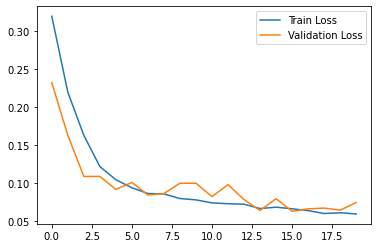

In [ ]:
plt.plot(train_running_loss_history, label = 'Train Loss')
plt.plot(validation_running_loss_history, label = 'Validation Loss')
plt.legend()

In [ ]:
model.eval()
X_train.size()

torch.Size([1, 1, 572, 572])

In [ ]:
torch.save(model, os.path.join(parent_folder, 'savedmodel/UNet++.pt'))

# You can load a model instead

In [ ]:
model = torch.load(os.path.join(parent_folder, 'savedmodel/UNet++.pt'))
model.to('cuda')
model.eval()

UNet_2Plus(
  (conv00): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv10): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

In [ ]:
def avg_dice_index(dataloader):
    dice = 0.0
    model.eval()
    with torch.no_grad():
        for ith_batch, sample_batched in enumerate(dataloader):
            X_train = sample_batched['image'].to('cuda')
            y_train = sample_batched['annotation'].to('cuda')
            y_predict = (model(X_train) + 0.5).int().float()
            dice += dice_index(y_predict, y_train)
    avg_dice = dice / len(dataloader)
    return avg_dice.item()

In [ ]:
avg_dice_index(validation_loader)    #### Dice index of validation data

/mmfs1/data/licds/.local/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.9463185667991638

In [ ]:
avg_dice_index(train_loader)    #### Dice index of validation data

0.9438002705574036